# Basic Gene Expression Model (Thattai-van Oudenaarden)

This notebook demonstrates the classic two-stage gene expression model introduced by [Thattai & van Oudenaarden (2001)](https://doi.org/10.1073/pnas.151588598). The model consists of four key reactions:

1. **Transcription**: DNA → mRNA (rate constant k_m)
2. **Translation**: mRNA → mRNA + Protein (rate constant k_p)  
3. **mRNA degradation**: mRNA → ∅ (rate constant γ_m)
4. **Protein degradation**: Protein → ∅ (rate constant γ_p)

This simple model captures the essential dynamics of gene expression and has been widely used to study intrinsic noise in gene regulatory networks. The model uses mass action kinetics and can be simulated using stochastic simulation algorithms (SSA) or solved deterministically as an ODE system. We'll demonstrate both parameter optimization using stochastic gradients and ODE-based training to fit the model to a target protein steady-state level.

In [ ]:
import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as rng
import matplotlib.pyplot as plt

# training deps
import optax
from tqdm import tqdm

import stochastix as stx

jax.config.update('jax_enable_x64', True)
key = rng.PRNGKey(42)

plt.rcParams['font.size'] = 18

In [2]:
# Define initial parameters

log_k_m = jnp.array(-4.7)
log_k_p = jnp.array(-3.7)
log_gamma_m = jnp.array(-5.2)
log_gamma_p = jnp.array(-6.0)

print(f'k_m:\t\t{jnp.exp(log_k_m):.3f} (1/s)')
print(f'k_p:\t\t{jnp.exp(log_k_p):.3f} (1/s)')
print(f'gamma_m:\t{jnp.exp(log_gamma_m):.3f} (1/s)')
print(f'gamma_p:\t{jnp.exp(log_gamma_p):.3f} (1/s)')
print('-' * 25)

# Print the steady-state protein level
Pss_init = jnp.exp(log_k_m + log_k_p - log_gamma_m - log_gamma_p)
print(f'Pss:\t~ {Pss_init:.0f} molecules')

k_m:		0.009 (1/s)
k_p:		0.025 (1/s)
gamma_m:	0.006 (1/s)
gamma_p:	0.002 (1/s)
-------------------------
Pss:	~ 16 molecules


In [ ]:
from stochastix import Reaction, ReactionNetwork
from stochastix.kinetics import MassAction

network = ReactionNetwork(
    [
        Reaction(
            '0 -> mRNA',
            MassAction(log_k_m, transform=jnp.exp),
            name='transcription',
        ),
        Reaction(
            'mRNA -> mRNA + P',
            MassAction(log_k_p, transform=jnp.exp),
            name='translation',
        ),
        Reaction(
            'mRNA -> 0',
            MassAction(log_gamma_m, transform=jnp.exp),
            name='mrna_degradation',
        ),
        Reaction(
            'P -> 0',
            MassAction(log_gamma_p, transform=jnp.exp),
            name='protein_degradation',
        ),
    ]
)

# couple reaction network to stochastic solver in a convenient way
model = stx.StochasticModel(network, stx.DifferentiableDirect(), T=3600.0)

# mean field model with diffrax solver
mf_model = stx.MeanFieldModel(network, T=3600.0)

print(network)

R0 (transcription):        0 -> mRNA         |  MassAction
R1 (translation):          mRNA -> P + mRNA  |  MassAction
R2 (mrna_degradation):     mRNA -> 0         |  MassAction
R3 (protein_degradation):  P -> 0            |  MassAction


In [4]:
# show latex-formatted equations
from IPython.display import Latex, display

display(Latex(network.to_latex()))

<IPython.core.display.Latex object>

## Stochastic Simulations

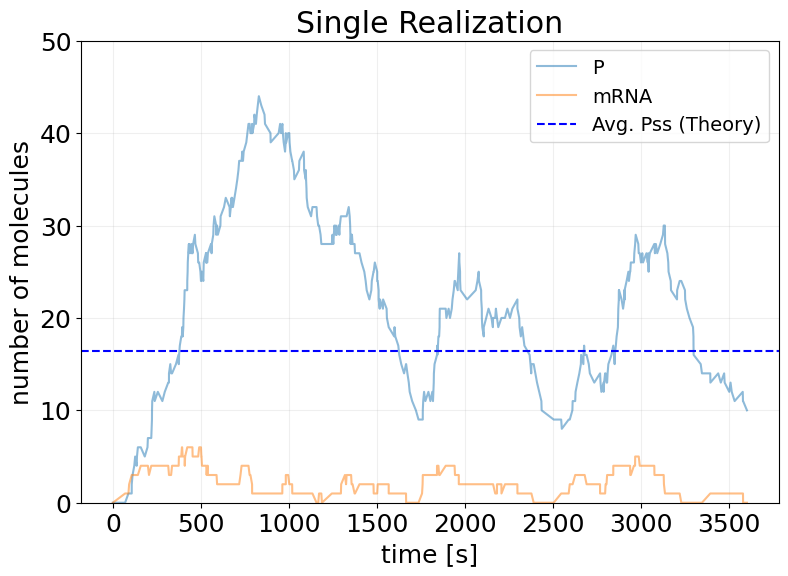

In [ ]:
## Single Realization

key, subkey = rng.split(key)

x0 = jnp.array([0.0, 0.0])

sim_results = model(subkey, x0)

fig, ax = stx.plot_abundance_dynamic(sim_results)
ax.axhline(Pss_init, color='b', linestyle='--', label='Avg. Pss (Theory)')
ax.set_ylim(0, 50)
ax.set_title('Single Realization')
ax.legend(fontsize=14);

In [6]:
## Ensemble Simulation

key, *subkeys = rng.split(key, 51)
subkeys = jnp.array(subkeys)

x0 = jnp.array([0.0, 0.0])

sim_init_ensemble_fn = eqx.filter_vmap(model, in_axes=(0, None))
sim_init_ensemble = sim_init_ensemble_fn(subkeys, x0)

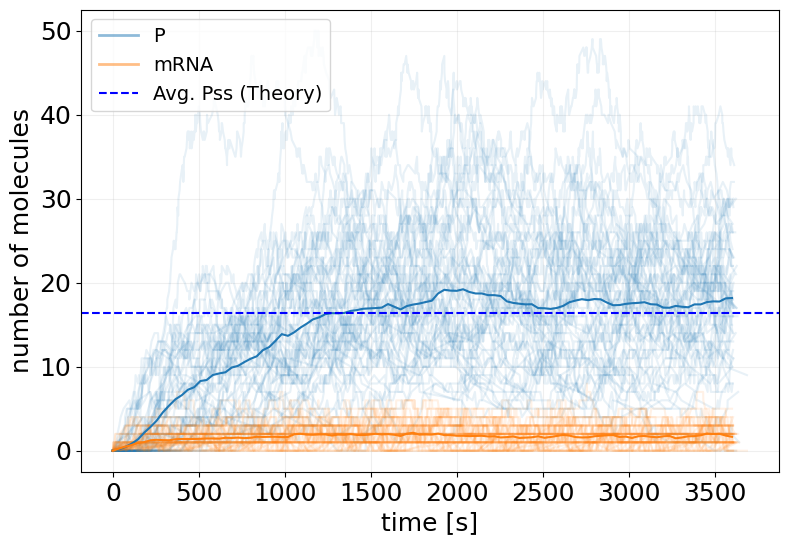

In [ ]:
fig, ax = stx.plot_abundance_dynamic(sim_init_ensemble, line_alpha=0.1)

t_interp = jnp.linspace(0, model.T, 100)
x_interp = sim_init_ensemble.interpolate(t_interp).x

ax.plot(t_interp, x_interp.mean(axis=0))
ax.axhline(Pss_init, color='b', linestyle='--', label='Avg. Pss (Theory)')

ax.legend(fontsize=14)
plt.show()

## Reparameterized Training

In [8]:
def loss_fn(model, x, y, key):
    sim_results = model(key, x)

    prot_idx = sim_results.species.index('P')

    return jnp.power(sim_results.x[-1, prot_idx] - y, 2)

In [9]:
def train_fstate(
    key,
    model,
    x0,
    y,
    LOSS_FN,
    EPOCHS=20,
    BATCH_SIZE=32,
    LEARNING_RATE=1e-3,
):
    # trick to vmap over named arguments
    loss_and_grads = eqx.filter_value_and_grad(LOSS_FN)
    loss_and_grads = eqx.filter_vmap(loss_and_grads, in_axes=(None, None, None, 0))

    losses = []

    opt = optax.adam(LEARNING_RATE)
    opt_state = opt.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(model, opt_state, key):
        key, *subkeys = rng.split(key, BATCH_SIZE + 1)
        subkeys = jnp.array(subkeys)

        loss, grads = loss_and_grads(model, x0, y, subkeys)

        grads = jax.tree.map(lambda x: x.mean(axis=0), grads)

        updates, opt_state = opt.update(grads, opt_state, model)

        model = eqx.apply_updates(model, updates)

        return model, opt_state, loss.mean()

    epoch_subkeys = rng.split(key, EPOCHS)

    pbar = tqdm(epoch_subkeys)
    for epoch_key in pbar:
        try:
            model, opt_state, loss = make_step(model, opt_state, epoch_key)

            losses += [float(loss)]

            pbar.set_description(f'Loss: {loss:.2f}')

        except KeyboardInterrupt:
            print('Training Interrupted')
            break

    log = {'loss': losses}

    return model, log

In [10]:
TARGET_PSS = 100.0

key, train_key = rng.split(key)

reparam_trained_model, log = train_fstate(
    train_key,
    model,
    x0,
    y=TARGET_PSS,
    LOSS_FN=loss_fn,
    EPOCHS=100,
    BATCH_SIZE=32,
    LEARNING_RATE=1e-2,
)

Loss: 1040.84: 100%|██████████| 100/100 [00:31<00:00,  3.14it/s]


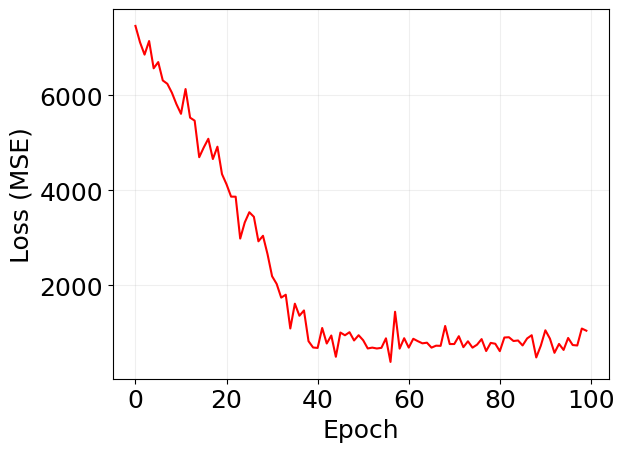

In [11]:
plt.plot(log['loss'], 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')

plt.grid(alpha=0.2)

In [12]:
print('REPARAMETERIZED (Gumbel-Softmax) GRADIENT:')
print('-' * 45)

new_log_k_m = reparam_trained_model.network.transcription.kinetics.k
new_log_k_p = reparam_trained_model.network.translation.kinetics.k
new_log_gamma_m = reparam_trained_model.network.mrna_degradation.kinetics.k
new_log_gamma_p = reparam_trained_model.network.protein_degradation.kinetics.k

print(f'k_m:\t\t{jnp.exp(new_log_k_m):.3f} (old: {jnp.exp(log_k_m):.3f})')
print(f'k_p:\t\t{jnp.exp(new_log_k_p):.3f} (old: {jnp.exp(log_k_p):.3f})')
print(f'gamma_m:\t{jnp.exp(new_log_gamma_m):.3f} (old: {jnp.exp(log_gamma_m):.3f})')
print(f'gamma_p:\t{jnp.exp(new_log_gamma_p):.3f} (old: {jnp.exp(log_gamma_p):.3f})')
print('-' * 45)

# Calculate the steady-state protein level for the trained model
Pss_trained = jnp.exp(new_log_k_m + new_log_k_p - new_log_gamma_m - new_log_gamma_p)
print(f'New Pss:\t~ {Pss_trained:.0f} molecules (old: ~ {Pss_init:.0f})')

REPARAMETERIZED (Gumbel-Softmax) GRADIENT:
---------------------------------------------
k_m:		0.015 (old: 0.009)
k_p:		0.036 (old: 0.025)
gamma_m:	0.004 (old: 0.006)
gamma_p:	0.002 (old: 0.002)
---------------------------------------------
New Pss:	~ 98 molecules (old: ~ 16)


In [13]:
## Ensemble Simulation

key, *subkeys = rng.split(key, 51)
subkeys = jnp.array(subkeys)

x0 = jnp.array([0.0, 0.0])

sim_reparam_ensemble_fn = eqx.filter_vmap(reparam_trained_model, in_axes=(0, None))
sim_reparam_ensemble = sim_reparam_ensemble_fn(subkeys, x0)

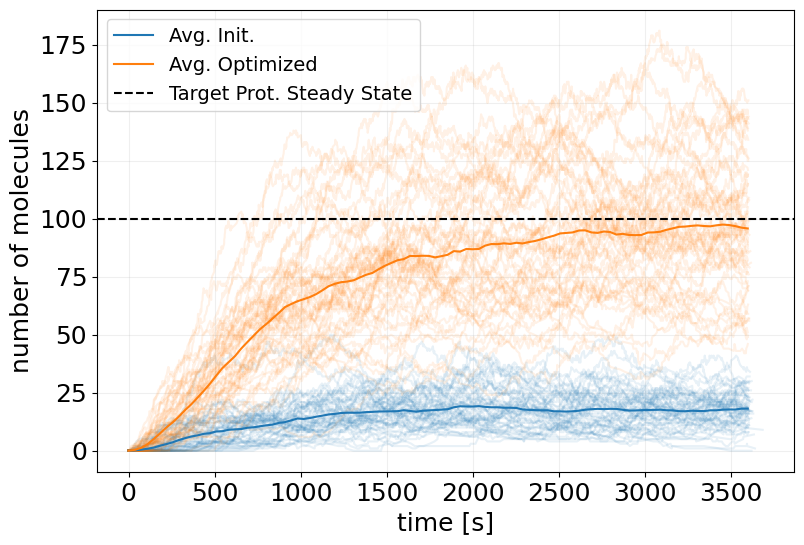

In [ ]:
# plot initial ensemble
fig, ax = stx.plot_abundance_dynamic(
    sim_init_ensemble, 'P', line_alpha=0.1, legend=False
)

# plot trained ensemble
_, ax = stx.plot_abundance_dynamic(
    sim_reparam_ensemble, 'P', line_alpha=0.1, ax=ax, legend=False
)

# plot mean trajectories
t_interp = jnp.linspace(0, model.T, 100)
x_interp = sim_init_ensemble.interpolate(t_interp).x
x_interp_trained = sim_reparam_ensemble.interpolate(t_interp).x

ax.plot(t_interp, x_interp.mean(axis=0)[:, 0], label='Avg. Init.')
ax.plot(t_interp, x_interp_trained.mean(axis=0)[:, 0], label='Avg. Optimized')

ax.axhline(TARGET_PSS, color='k', linestyle='--', label='Target Prot. Steady State')

ax.legend(fontsize=14)
plt.show()

## REINFORCE Training

In [ ]:
from stochastix.utils.optimization import (
    discounted_returns,
    neg_final_state_distance,
    reinforce_loss,
)

In [16]:
# training
def train_fstate_reinforce(
    key,
    model,
    x0,
    y,
    REWARDS_FN,
    LOSS_FN,
    EPOCHS=20,
    LEARNING_RATE=1e-3,
    BATCH_SIZE=32,
    REW_DISCOUNT=1.0,
    rew_avg_baseline=True,
):
    # trick to vmap over named arguments
    rewards_fn = lambda x, y: REWARDS_FN(x, target_ss=y)
    loss_and_grads = eqx.filter_vmap(
        eqx.filter_value_and_grad(LOSS_FN),
        in_axes=(None, eqx.if_array(0), 0),  # network, sim_results, rewards
    )

    losses = []
    rewards = []

    opt = optax.adam(LEARNING_RATE)
    opt_state = opt.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(model, opt_state, key):
        key, *subkeys = rng.split(key, BATCH_SIZE + 1)
        subkeys = jnp.array(subkeys)

        # TODO: check time overflow with checkify
        sim_results = eqx.filter_vmap(model, in_axes=(0, None))(subkeys, x0)

        rewards = eqx.filter_vmap(rewards_fn, in_axes=(eqx.if_array(0), None))(
            sim_results, y
        )

        returns = eqx.filter_vmap(discounted_returns, in_axes=(0, None))(
            rewards, REW_DISCOUNT
        )
        if rew_avg_baseline:
            returns = returns - returns.mean(axis=0)

        loss, grads = loss_and_grads(model, sim_results, returns)

        grads = jax.tree.map(lambda x: x.mean(axis=0), grads)

        updates, opt_state = opt.update(grads, opt_state, model)

        model = eqx.apply_updates(model, updates)

        rewards = jnp.mean(rewards.sum(axis=1))

        return model, opt_state, loss.mean(), rewards

    epoch_subkeys = rng.split(key, EPOCHS)

    pbar = tqdm(epoch_subkeys)
    for epoch_key in pbar:
        try:
            model, opt_state, loss, reward = make_step(model, opt_state, epoch_key)

            losses += [float(loss)]
            rewards += [float(reward)]

            pbar.set_description(f'Loss: {loss:.2f}, Reward: {reward:.2f}')

        except KeyboardInterrupt:
            print('Training Interrupted')
            break

        log = {'loss': losses, 'reward': rewards}

    return model, log

In [17]:
# train model

rewards_fn = neg_final_state_distance(species='P', distance='L2')

# create loss function
rloss_fn = reinforce_loss()

TARGET_PSS = 100.0

key, train_key = rng.split(key)

pg_trained_model, log_pg = train_fstate_reinforce(
    train_key,
    model,
    x0,
    TARGET_PSS,
    rewards_fn,
    rloss_fn,
    EPOCHS=150,
    LEARNING_RATE=1e-2,
    BATCH_SIZE=64,
    REW_DISCOUNT=1.0,
    rew_avg_baseline=True,
)

Loss: -225813.66, Reward: -698.88: 100%|██████████| 150/150 [01:13<00:00,  2.04it/s] 


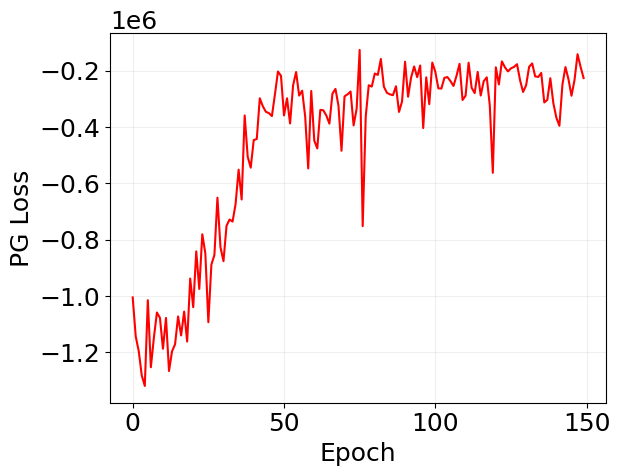

In [18]:
plt.plot(log_pg['loss'], 'r')
plt.xlabel('Epoch')
plt.ylabel('PG Loss')

plt.grid(alpha=0.2)

plt.show()

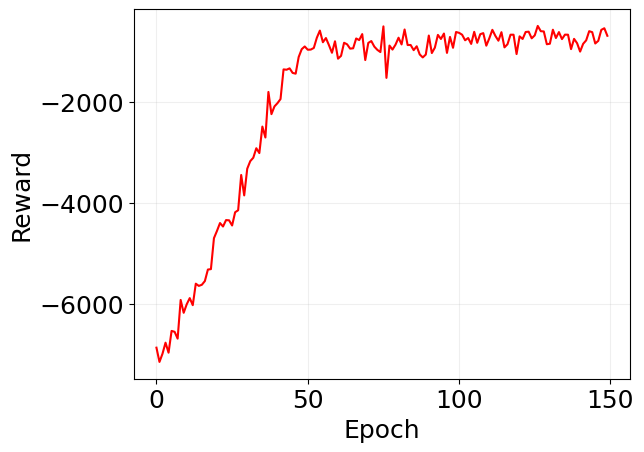

In [19]:
plt.plot(jnp.array(log_pg['reward']), 'r')
plt.xlabel('Epoch')
plt.ylabel('Reward')

plt.grid(alpha=0.2)

plt.show()

In [20]:
print('REINFORCE GRADIENT:')
print('-' * 45)

new_log_k_m = pg_trained_model.network.transcription.kinetics.k
new_log_k_p = pg_trained_model.network.translation.kinetics.k
new_log_gamma_m = pg_trained_model.network.mrna_degradation.kinetics.k
new_log_gamma_p = pg_trained_model.network.protein_degradation.kinetics.k

print(f'k_m:\t\t{jnp.exp(new_log_k_m):.3f} (old: {jnp.exp(log_k_m):.3f})')
print(f'k_p:\t\t{jnp.exp(new_log_k_p):.3f} (old: {jnp.exp(log_k_p):.3f})')
print(f'gamma_m:\t{jnp.exp(new_log_gamma_m):.3f} (old: {jnp.exp(log_gamma_m):.3f})')
print(f'gamma_p:\t{jnp.exp(new_log_gamma_p):.3f} (old: {jnp.exp(log_gamma_p):.3f})')
print('-' * 45)

# Calculate the steady-state protein level for the trained model
Pss_trained = jnp.exp(new_log_k_m + new_log_k_p - new_log_gamma_m - new_log_gamma_p)
print(f'New Pss:\t~ {Pss_trained:.0f} molecules (old: ~ {Pss_init:.0f})')

REINFORCE GRADIENT:
---------------------------------------------
k_m:		0.018 (old: 0.009)
k_p:		0.032 (old: 0.025)
gamma_m:	0.003 (old: 0.006)
gamma_p:	0.002 (old: 0.002)
---------------------------------------------
New Pss:	~ 97 molecules (old: ~ 16)


In [21]:
## Ensemble Simulation

key, *subkeys = rng.split(key, 51)
subkeys = jnp.array(subkeys)

x0 = jnp.array([0.0, 0.0])

sim_pg_ensemble_fn = eqx.filter_vmap(pg_trained_model, in_axes=(0, None))
sim_pg_ensemble = sim_pg_ensemble_fn(subkeys, x0)

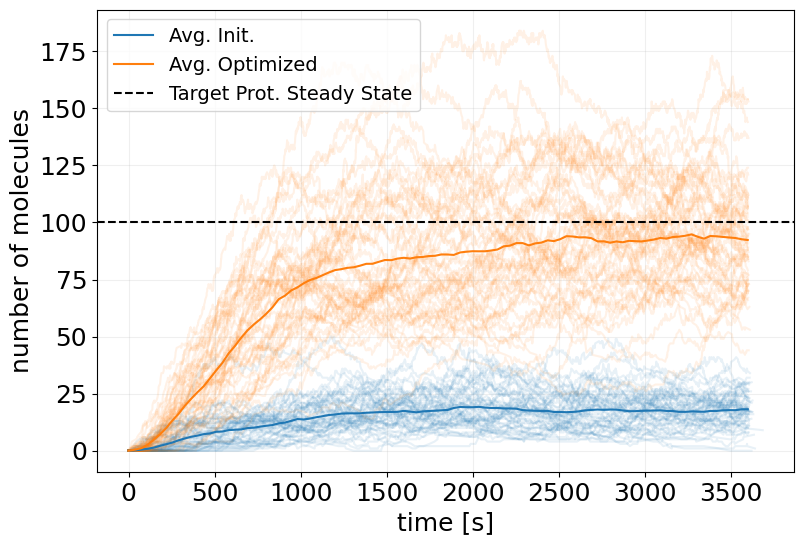

In [ ]:
# plot initial ensemble
fig, ax = stx.plot_abundance_dynamic(
    sim_init_ensemble, 'P', line_alpha=0.1, legend=False
)

# plot trained ensemble
_, ax = stx.plot_abundance_dynamic(
    sim_pg_ensemble, 'P', line_alpha=0.1, ax=ax, legend=False
)

# plot mean trajectories
t_interp = jnp.linspace(0, model.T, 100)
x_interp = sim_init_ensemble.interpolate(t_interp).x
x_interp_trained = sim_pg_ensemble.interpolate(t_interp).x

ax.plot(t_interp, x_interp.mean(axis=0)[:, 0], label='Avg. Init.')
ax.plot(t_interp, x_interp_trained.mean(axis=0)[:, 0], label='Avg. Optimized')

ax.axhline(TARGET_PSS, color='k', linestyle='--', label='Target Prot. Steady State')

ax.legend(fontsize=14)
plt.show()

## Mean Field Training

In [23]:
TARGET_PSS = 100.0

key, train_key = rng.split(key)

mf_trained_model, log_mf = train_fstate(
    train_key,
    mf_model,
    x0,
    y=TARGET_PSS,
    LOSS_FN=loss_fn,
    EPOCHS=1000,
    BATCH_SIZE=1,
    LEARNING_RATE=1e-3,
)

Loss: 0.00: 100%|██████████| 1000/1000 [00:04<00:00, 211.80it/s]  


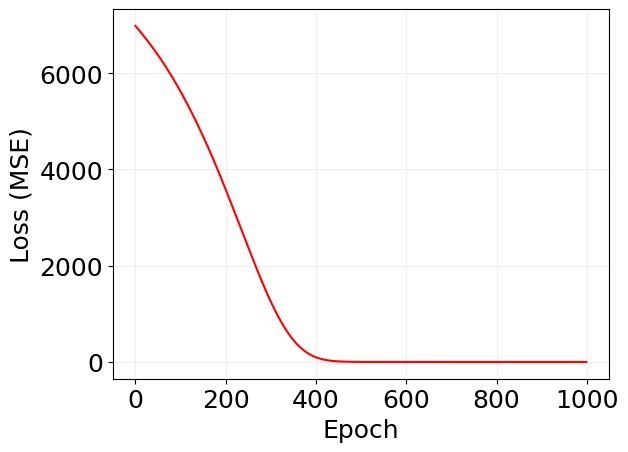

In [24]:
plt.plot(log_mf['loss'], 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')

# plt.yscale('log')

plt.grid(alpha=0.2)

In [25]:
print('Mean Field (ODE) GRADIENT:')
print('-' * 45)

new_log_k_m = mf_trained_model.network.transcription.kinetics.k
new_log_k_p = mf_trained_model.network.translation.kinetics.k
new_log_gamma_m = mf_trained_model.network.mrna_degradation.kinetics.k
new_log_gamma_p = mf_trained_model.network.protein_degradation.kinetics.k

print(f'k_m:\t\t{jnp.exp(new_log_k_m):.3f} (old: {jnp.exp(log_k_m):.3f})')
print(f'k_p:\t\t{jnp.exp(new_log_k_p):.3f} (old: {jnp.exp(log_k_p):.3f})')
print(f'gamma_m:\t{jnp.exp(new_log_gamma_m):.3f} (old: {jnp.exp(log_gamma_m):.3f})')
print(f'gamma_p:\t{jnp.exp(new_log_gamma_p):.3f} (old: {jnp.exp(log_gamma_p):.3f})')
print('-' * 45)

# Calculate the steady-state protein level for the trained model
Pss_trained = jnp.exp(new_log_k_m + new_log_k_p - new_log_gamma_m - new_log_gamma_p)
print(f'New Pss:\t~ {Pss_trained:.0f} molecules (old: ~ {Pss_init:.0f})')

Mean Field (ODE) GRADIENT:
---------------------------------------------
k_m:		0.014 (old: 0.009)
k_p:		0.039 (old: 0.025)
gamma_m:	0.004 (old: 0.006)
gamma_p:	0.002 (old: 0.002)
---------------------------------------------
New Pss:	~ 101 molecules (old: ~ 16)


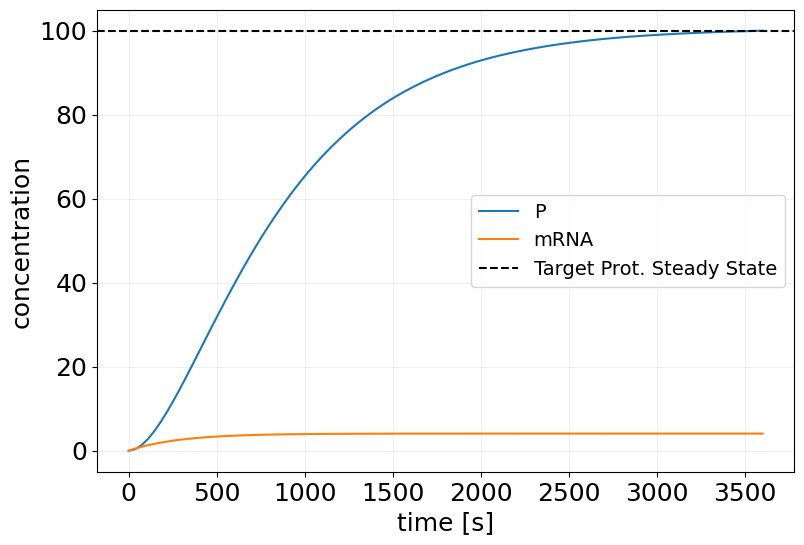

In [ ]:
sim_mf_trained = mf_trained_model(key, x0, saveat_steps=100)

plt.figure(figsize=(9, 6))
plt.plot(sim_mf_trained.t, sim_mf_trained.x, label=sim_mf_trained.species)

plt.xlabel('time [s]')
plt.ylabel('concentration')

plt.axhline(TARGET_PSS, color='k', linestyle='--', label='Target Prot. Steady State')

plt.grid(alpha=0.2)

plt.legend(fontsize=14)

## Comparison

In [ ]:
def sim_mf_ensemble_fn(ks, x0):
    sol = stx.stochsimsolve(ks, mf_trained_model.network, x0, T=mf_trained_model.T)
    return sol


sim_mf_ensemble_fn = eqx.filter_vmap(sim_mf_ensemble_fn, in_axes=(0, None))

In [28]:
# Sample from distributions
n_samples = 1024

key, *subkeys = rng.split(key, n_samples + 1)
subkeys = jnp.array(subkeys)

x0 = jnp.array([0.0, 0.0])

init_distr = sim_init_ensemble_fn(subkeys, x0).x[:, -1, 0]
print('Init. Mean:', init_distr.mean())
print('Init. Std:', init_distr.std())
print()

ode_distr = sim_mf_ensemble_fn(subkeys, x0).x[:, -1, 0]
print('ODE Mean:', ode_distr.mean())
print('ODE Std:', ode_distr.std())
print()

pg_distr = sim_pg_ensemble_fn(subkeys, x0).x[:, -1, 0]
print('PG Mean:', pg_distr.mean())
print('PG Std:', pg_distr.std())
print()

reparam_distr = sim_reparam_ensemble_fn(subkeys, x0).x[:, -1, 0]
print('Repar. Mean:', reparam_distr.mean())
print('Repar. Std:', reparam_distr.std())
print()

Init. Mean: 16.34375
Init. Std: 8.622338810467841

ODE Mean: 100.6943359375
ODE Std: 30.307817408110996

PG Mean: 96.876953125
PG Std: 25.87380160445219

Repar. Mean: 97.1865234375
Repar. Std: 28.402268251316887



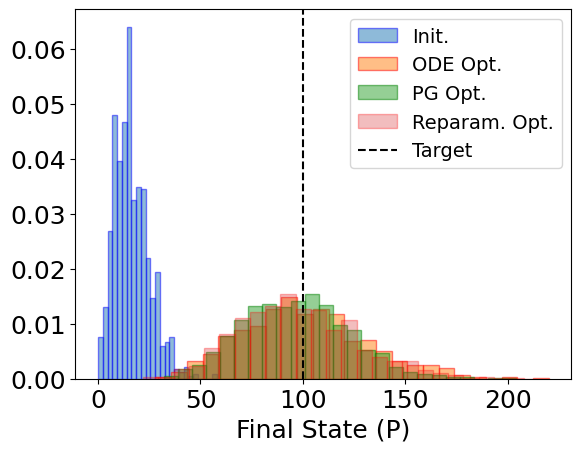

In [29]:
plt.hist(init_distr, bins=25, alpha=0.5, label='Init.', density=True, edgecolor='b')
plt.hist(ode_distr, bins=25, alpha=0.5, label='ODE Opt.', density=True, edgecolor='r')
plt.hist(pg_distr, bins=25, alpha=0.5, label='PG Opt.', density=True, edgecolor='g')
plt.hist(
    reparam_distr,
    bins=25,
    alpha=0.3,
    label='Reparam. Opt.',
    density=True,
    edgecolor='r',
)

plt.axvline(100, color='k', linestyle='--', label='Target')

plt.xlabel('Final State (P)')

plt.legend(fontsize=14)

plt.show()

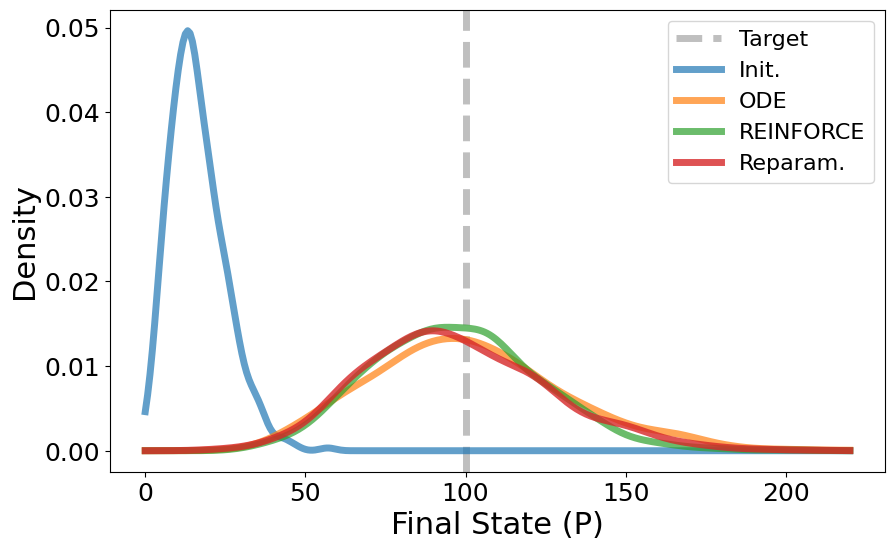

In [30]:
import numpy as np
from scipy.stats import gaussian_kde

plt.figure(figsize=(10, 6))

plt.axvline(
    TARGET_PSS, color='gray', linestyle='--', linewidth=5, label='Target', alpha=0.5
)


# Create x range for smooth curves
x_min = min(init_distr.min(), ode_distr.min(), pg_distr.min(), reparam_distr.min())
x_max = max(init_distr.max(), ode_distr.max(), pg_distr.max(), reparam_distr.max())
x_range = np.linspace(x_min, x_max, 300)

# Create KDE for each distribution and plot
kde_init = gaussian_kde(init_distr)
plt.plot(x_range, kde_init(x_range), alpha=0.7, label='Init.', linewidth=5)

kde_ode = gaussian_kde(ode_distr)
plt.plot(x_range, kde_ode(x_range), alpha=0.7, label='ODE', linewidth=5)

kde_pg = gaussian_kde(pg_distr)
plt.plot(x_range, kde_pg(x_range), alpha=0.7, label='REINFORCE', linewidth=5)

kde_reparam = gaussian_kde(reparam_distr)
plt.plot(x_range, kde_reparam(x_range), alpha=0.8, label='Reparam.', linewidth=5)


plt.xlabel('Final State (P)', fontsize=22)
plt.ylabel('Density', fontsize=22)

plt.legend(fontsize=16)

plt.show()